In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import functools

from datetime import timedelta

import jax
import xarray

import numpy as np
import jax.numpy as jnp

from graphcast import xarray_jax

from data_loading import load_data
from model_running import (
    multi_step_forward_jit, forward_fn_jitted, build_static_data_selector,
    approx_forward_fn_jitted, task_config,
)
from attacks import add_perturbation, our_attack

In [3]:
import json

with open("data/geoBoundariesCGAZ_ADM0.geojson", "r") as f:
    boundary_data = json.load(f)

In [4]:
def smooth(points):
    new_points = [points[0]]
    def distance(p1, p2):
        return ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)**0.5
    for point in points[1:]:
        if distance(point, new_points[-1]) < 0.2:
            continue
        new_points.append(point)
    return new_points

def to_svg_path(points):
    assert len(points) > 1
    s = f"M{points[0][0]} {-points[0][1]}"
    for point in points[1:]:
        s += f" L{point[0]} {-point[1]}"
    s += " Z"
    return f'<path d="{s}" stroke="black" fill="#eee" fill-opacity="1.0"/>'

def filter_boundaries(feature):
    def is_in_bounds(coord):
        lon, lat = coord
        if lat < 30 or lat > 60:
            return False
        if lon < -15 or lon > 40:
            return False
        return True
    return list(filter(
        lambda boundary: len(boundary) > 5 and any(is_in_bounds(coord) for coord in boundary),
        (
            smooth(boundary) if feature["geometry"]["type"] == "Polygon" else smooth(boundary[0])
            for boundary in feature["geometry"]["coordinates"])
    ))

In [5]:
all_paths = sum(
    (
        list(
            map(to_svg_path, filter_boundaries(boundaries)
            )
        )
        for boundaries in boundary_data["features"]
    ), start=[]
)

In [6]:
def general_loss_fn(
        rng,
        inputs,
        targets,
        forcings,
        forward_fn,
        variable_selection_fn,
        region_selection_fn,
    ):
    denoised_predictions = multi_step_forward_jit(
        rng,
        inputs,
        targets,
        forcings,
        forward_fn
    ).isel(time=-1)

    # select target variable
    target = variable_selection_fn(denoised_predictions)

    # select target region
    target = xarray_jax.unwrap_data(target, require_jax=True)
    target = region_selection_fn(target)

    loss = jnp.mean(target)
    return loss

# no jit, as it does not provide a speedup in this case
precise_loss_fn = lambda rng, i, t, f, s, v: general_loss_fn(rng, i, t, f, forward_fn_jitted, v, s)

def adv_grads_fn(rng, inputs, targets, forcings, approximation_steps, variable_selection_fn, region_selection_fn):
    forward_fn = functools.partial(approx_forward_fn_jitted, approximation_steps=approximation_steps)
    def _aux(rng, i, t, f):
        loss = general_loss_fn(
            rng, i, t, f,
            forward_fn=forward_fn,
            variable_selection_fn=variable_selection_fn,
            region_selection_fn=region_selection_fn,
        )
        return loss

    loss, grads = jax.value_and_grad(
        _aux,
        argnums=1,
    )(rng, inputs, targets, forcings)
    return loss, grads
adv_grads_fn_jitted = jax.jit(adv_grads_fn, static_argnums=(4,5,6))

In [7]:
era5 = xarray.open_zarr("gs://weatherbench2/datasets/era5/1959-2023_01_10-wb13-6h-1440x721_with_derived_variables.zarr")

In [8]:
era5 = era5.isel(time=slice(1, None, 2))

In [9]:
single_sample = era5.isel(time=0).compute()
single_sample = single_sample.rename_dims(dict(latitude="lat", longitude="lon"))
single_sample = single_sample.rename_vars(dict(latitude="lat", longitude="lon"))
single_sample = single_sample.isel(lat=slice(None, None, -1))

In [10]:
inputs, targets, forcings = load_data(era5, "2006-07-17T06:00:00", task_config, lead_time=timedelta(days=2.5))

In [11]:
import matplotlib.pyplot as plt

Array(34.51001, dtype=float32)

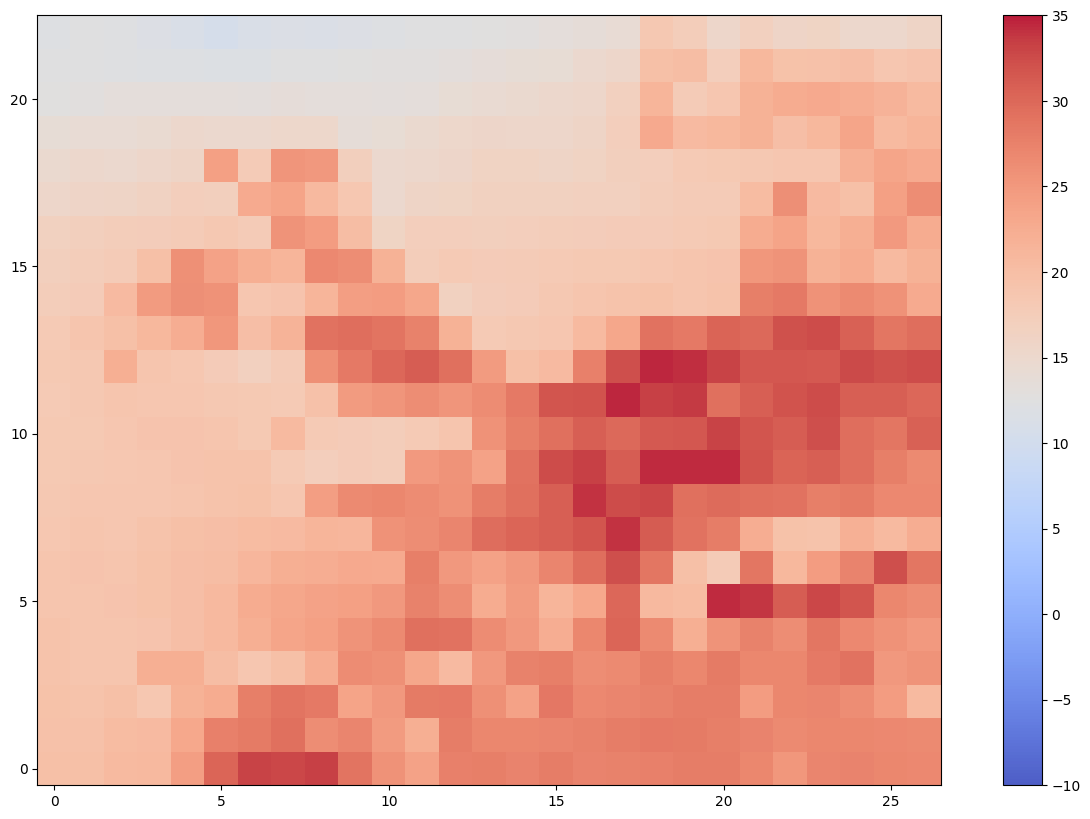

In [12]:
unperturbed_temp = targets["2m_temperature"].isel(batch=0, time=-1).data
selected_temp = build_static_data_selector(inputs.coords, 40, 62, -12, 14)(targets["2m_temperature"].isel(batch=0, time=-1).data) - 273
selected_mask = build_static_data_selector(single_sample.coords, 40, 62, -12, 14)(single_sample["land_sea_mask"].data)[::-1, ...]
fig, ax = plt.subplots(figsize=(16,10))
# ax.imshow(selected_mask, extent=[0, 14+12, 0, 62-40])
im = ax.imshow(selected_temp, cmap="coolwarm", vmin=-10, vmax=35, alpha=0.9)
ax.invert_yaxis()
fig.colorbar(im)
np.max(selected_temp)

In [13]:
variable_selector = lambda x: x["2m_temperature"]
region_selection_fn = build_static_data_selector(inputs.coords, 48, 56, 6, 14)

grads_fn = functools.partial(
    adv_grads_fn_jitted,
    region_selection_fn=region_selection_fn,
    variable_selection_fn=variable_selector
)

In [14]:
perturbation = our_attack(
    inputs,
    targets,
    forcings,
    0.07,
    grads_fn,
    maxiter=50,
    do_log=True,
)

/usr/local/lib/python3.12/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.12/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


0 299.10855
1 295.49652
2 291.54263
3 294.87943
4 289.37595
5 294.22232
6 294.04428
7 288.7632
8 288.46527
9 293.53156
10 293.74503
11 286.90903
12 288.32672
13 292.25046
14 286.2848
15 286.38275
16 285.6933
17 284.51663
18 286.15933
19 284.6044
20 286.95398
21 284.92493
22 284.43152
23 294.27026
24 285.25534
25 283.60648
26 283.3317
27 282.65848
28 283.9808
29 285.35083
30 296.39444
31 282.74768
32 284.4749
33 295.77628
34 283.2966
35 293.68668
36 284.15082
37 283.44308
38 295.06342
39 281.9522
40 283.22327
41 284.58496
42 284.1801
43 295.86285
44 282.90616
45 294.01913
46 295.4997
47 294.91687
48 283.07822
49 294.05716


In [15]:
denoised_predictions = multi_step_forward_jit(
    jax.random.PRNGKey(1234567890),
    add_perturbation(inputs, perturbation),
    targets,
    forcings,
    forward_fn_jitted,
)

/usr/local/lib/python3.12/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Array(26.843384, dtype=float32)

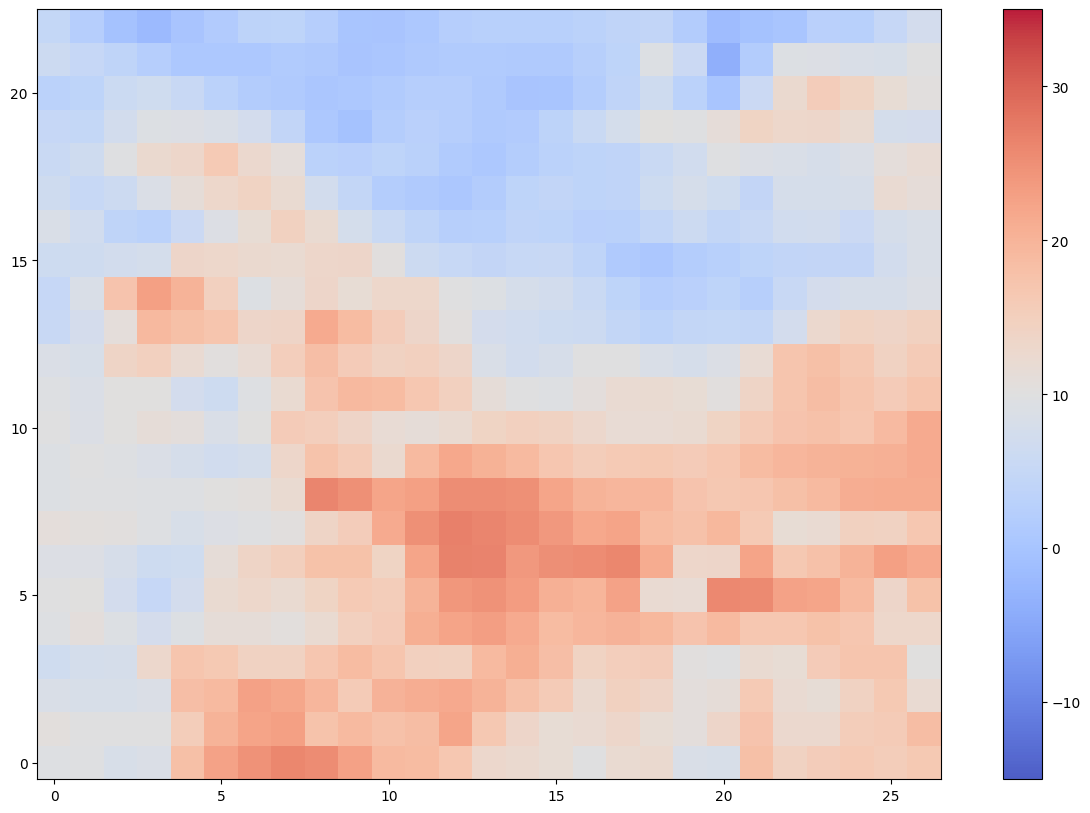

In [16]:
perturbed_temp = xarray_jax.unwrap_data(denoised_predictions["2m_temperature"].isel(time=-1, batch=0))
selected_temp = build_static_data_selector(inputs.coords, 40, 62, -12, 14)(xarray_jax.unwrap_data(denoised_predictions["2m_temperature"].isel(time=-1, batch=0))) - 273
selected_mask = build_static_data_selector(single_sample.coords, 40, 62, -12, 14)(single_sample["land_sea_mask"].data)[::-1, ...]
fig, ax = plt.subplots(figsize=(16,10))
# ax.imshow(selected_mask, extent=[0, 14+12, 0, 62-40])
im = ax.imshow(selected_temp, cmap="coolwarm", vmin=-15, vmax=35, alpha=0.9)
ax.invert_yaxis()
fig.colorbar(im)
np.max(selected_temp)

In [18]:
import matplotlib

cmap = matplotlib.colormaps["coolwarm"]
def svg_heat_map(values):
    start_x = -11
    start_y = 40
    width = 30
    height = 30
    values = build_static_data_selector(inputs.coords, start_y, start_y+height, start_x, start_x+width)(values) - 273
    
    def _to_hex_color(value):
        vmin = -15
        vmax = 35
        r,g,b,a = cmap((value - vmin) / (vmax - vmin))
        r = int(r * 255)
        g = int(g * 255)
        b = int(b * 255)
        return f"#{r:02x}{g:02x}{b:02x}"

    s = ""
    for dx in range(width):
        for dy in range(height):
            value = values[dy][dx]
            s += f'<rect width="1" height="1" x="{start_x+dx-0.5}" y="{-(start_y+dy)-0.5}" fill-opacity="0.8" fill="{_to_hex_color(value)}" stroke="none"/>'
    return s

In [21]:
NEWLINE = "\n"
with open("data/results/heat_case_study_before.svg", "w") as f:
    f.write(f'''<svg viewBox="-10 -57 27 11" xmlns="http://www.w3.org/2000/svg" style="stroke-width: 0.2%" clip-path="url(#clip)">
    <defs>
        <clipPath id="clip" clipPathUnits="userSpaceOnUse">
            <rect x="0" y="0" width="100%" height="100%" rx="1" ry="0.64"/>
        </clipPath>
    </defs>
    {NEWLINE.join(all_paths)}
    {svg_heat_map(unperturbed_temp)}
    <rect x="-10" y="-57" width="27" height="11" rx="1" ry="0.64" stroke="black" fill="none"/>
</svg>''')

In [22]:
NEWLINE = "\n"
with open("data/results/heat_case_study_after.svg", "w") as f:
    f.write(f'''<svg viewBox="-10 -57 27 11" xmlns="http://www.w3.org/2000/svg" style="stroke-width: 0.2%" clip-path="url(#clip)">
    <defs>
        <clipPath id="clip" clipPathUnits="userSpaceOnUse">
            <rect x="0" y="0" width="100%" height="100%" rx="1" ry="0.64"/>
        </clipPath>
    </defs>
    {NEWLINE.join(all_paths)}
    {svg_heat_map(perturbed_temp)}
    <rect width="8" height="8" stroke="#555" fill="none" y="-56.5" x="5.5" stroke-dasharray="1%"/>
    <rect x="-10" y="-57" width="27" height="11" rx="1" ry="0.64" stroke="black" fill="none"/>
</svg>''')